## yfinance Library Demo

### Disclaimers:

Trading stocks has it's own inherent risks. Trade at your own discretion. 
<br />

The predictions from the model is best thought of as correlations rather than causations.  

### Overview:

This notebook provides a random forest classifier model that predicts the direction of movement of a secruity in the next time interval.
<br />

The prediction is only for directions up 1 or down 0. 

### Imports: 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (8, 7)
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score
                             , precision_score
                             , recall_score
                             , roc_curve
                             , confusion_matrix
                             , plot_confusion_matrix
                             , precision_recall_curve
                             , auc
                            )

### Global Variables:

In [2]:
# yfinance automatically pull data up to the current time, unless specified 

# month = '06' # month and date not necessary if using fix period, see next cell
# date = '15'

# sf_hour = 13 # 6 to 13 military time in PST
# ny_hour = 4 # 9 to 16 military time in EST

# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
interval = '1d'

# time span of data e.g. 2y for 60m, 10y for 1d
period = '10y' 

perc_inc = 0.015 # 1.5 percent increase from hour to hour or any time period

# start = '2018-07-01'

# end = '2020-' + month + '-' + date

symbol = 'IYW' # ITOT iShares TOTAL Market ETF stock

perc_train = 0.25 # percent of train set

### Yahoo Finance

In [3]:
stock_df = yf.download(tickers = symbol # symbol of stock 
                       
                       , period = period
                       
                       , interval = interval # time periods of subinterval e.g. 1m or 1hr
                       
                       # , start = start # start date, time
                       
                       # , end = end # end date, time
                       
                       , prepost = True # pre/post market data
                      )

[*********************100%***********************]  1 of 1 completed


In [4]:
stock_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-21,25.735001,25.750000,25.295000,25.305000,20.638567,175200
2010-06-22,25.299999,25.440001,24.885000,24.885000,20.296022,102000
2010-06-23,24.840000,24.844999,24.620001,24.785000,20.297661,113400
2010-06-24,24.590000,24.620001,24.264999,24.309999,19.908657,36200
2010-06-25,24.385000,24.535000,24.250000,24.445000,20.019213,23800


### EDA of Secruity

In [5]:
stock_df['percent change'] = (stock_df.Open - stock_df.Close) / stock_df.Open
stock_df.head()

,Open,High,Low,Close,Adj Close,Volume,percent change
Date,,,,,,,
2010-06-21,25.735001,25.750000,25.295000,25.305000,20.638567,175200,0.016709
2010-06-22,25.299999,25.440001,24.885000,24.885000,20.296022,102000,0.016403
2010-06-23,24.840000,24.844999,24.620001,24.785000,20.297661,113400,0.002214
2010-06-24,24.590000,24.620001,24.264999,24.309999,19.908657,36200,0.011387
2010-06-25,24.385000,24.535000,24.250000,24.445000,20.019213,23800,-0.002461


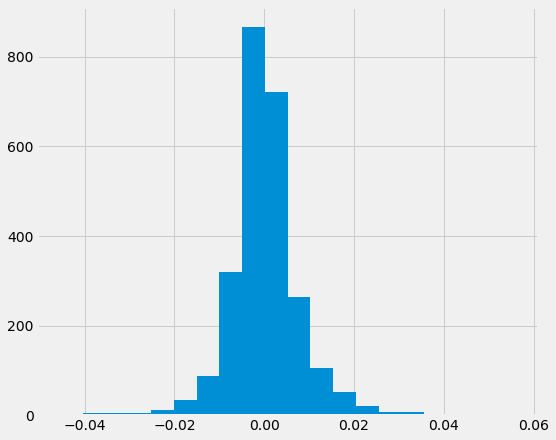

In [6]:
stock_df['percent change'].hist(bins=20);

In [7]:
stock_df['percent change'].quantile([0.84])

0.84    0.005926
Name: percent change, dtype: float64

### Assign Descisions for Up %+ or Not

In [8]:
stock_df['decision'] = np.where((stock_df['Close'] - stock_df['Open'])/stock_df['Open'] > perc_inc
                                
                                , 1  # 1 if up % or greater
                                
                                , 0  # 0 if not up % or greater
                                
                               )

In [9]:
stock_df.tail(15)

,Open,High,Low,Close,Adj Close,Volume,percent change,decision
Date,,,,,,,,
2020-06-01,68.070000,68.800003,68.000000,68.589996,68.312416,1558900,-0.007639,0
2020-06-02,68.800003,69.190002,68.519997,69.160004,68.880119,1685000,-0.005233,0
2020-06-03,69.730003,70.410004,69.669998,70.250000,69.965706,1806000,-0.007457,0
2020-06-04,69.970001,70.389999,69.500000,69.980003,69.696800,4518100,-0.000143,0
2020-06-05,71.449997,72.360001,71.209999,71.860001,71.569191,2454900,-0.005738,0
2020-06-08,72.169998,72.889999,72.010002,72.800003,72.505386,3395400,-0.008729,0
2020-06-09,72.120003,72.540001,71.820000,72.139999,71.848053,3788600,-0.000277,0
2020-06-10,72.239998,72.419998,71.419998,71.610001,71.320198,3886300,0.008721,0
2020-06-11,69.660004,69.949997,67.250000,67.449997,67.177032,3139900,0.031726,0


### Create One Offs

Move decision column up by 1 row so the current
hour of data will predict the next hour of data
or whichever time frame is observed

In [10]:
decisions = stock_df.decision.values
type(decisions)

numpy.ndarray

In [11]:
len(decisions)

2518

In [12]:
decisions = decisions[1:len(decisions)] # from rows 2 to 6061

In [13]:
len(decisions)

2517

In [14]:
stock_df_one_off = stock_df.iloc[0:stock_df.shape[0]-1] # from rows 1 to 6060
stock_df_one_off.shape

(2517, 8)

In [15]:
stock_df_one_off.iloc[-1]

Open                  69.339996
High                  69.940002
Low                   69.279999
Close                 69.809998
Adj Close             69.809998
Volume            966300.000000
percent change        -0.006778
decision               0.000000
Name: 2020-06-18 00:00:00, dtype: float64

In [16]:
stock_df_one_off['decision'] = decisions
stock_df_one_off.head()

,Open,High,Low,Close,Adj Close,Volume,percent change,decision
Date,,,,,,,,
2010-06-21,25.735001,25.750000,25.295000,25.305000,20.638567,175200,0.016709,0
2010-06-22,25.299999,25.440001,24.885000,24.885000,20.296022,102000,0.016403,0
2010-06-23,24.840000,24.844999,24.620001,24.785000,20.297661,113400,0.002214,0
2010-06-24,24.590000,24.620001,24.264999,24.309999,19.908657,36200,0.011387,0
2010-06-25,24.385000,24.535000,24.250000,24.445000,20.019213,23800,-0.002461,0


In [17]:
stock_df_one_off.decision.value_counts() # there is an inablance between 0's and 1's

0    2366
1     151
Name: decision, dtype: int64

### Balance the 0's and 1's

In [18]:
ones = stock_df_one_off.decision.value_counts()[1]
ones

151

In [19]:
stock_df_bal = stock_df_one_off.groupby('decision').apply(lambda x: x.sample(n=ones)).reset_index(drop=True)

In [20]:
stock_df_bal.shape

(302, 8)

In [21]:
stock_df_bal.decision.value_counts()

1    151
0    151
Name: decision, dtype: int64

### Check for NaN's

In [22]:
stock_df_bal.isna().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
percent change    0
decision          0
dtype: int64

In [23]:
stock_df_bal.dropna(axis=0, inplace=True)

In [24]:
stock_df_bal.isna().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
percent change    0
decision          0
dtype: int64

### Train Test Split

In [25]:
X = stock_df_bal.drop(columns=['percent change', 'decision']) # get columns other than decision
y = stock_df_bal['decision'] # get decision column

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X
                                                    , y
                                                    , test_size=0.20
                                                    , random_state = 42
                                                   )

### Random Forest Classifier

In [27]:
rfc = RandomForestClassifier(n_estimators = int(perc_train * len(X_train)) # odd number 
                             , random_state = 42
                             , verbose=1
                             , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                            )

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

y_probs = rfc.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:    0.0s finished


### Measures of Performances: Receiver Operating Characteristic (ROC) Curve

In [28]:
roc_value = roc_auc_score(y_test
                          , y_probs
                         )
roc_value

0.7672043010752688

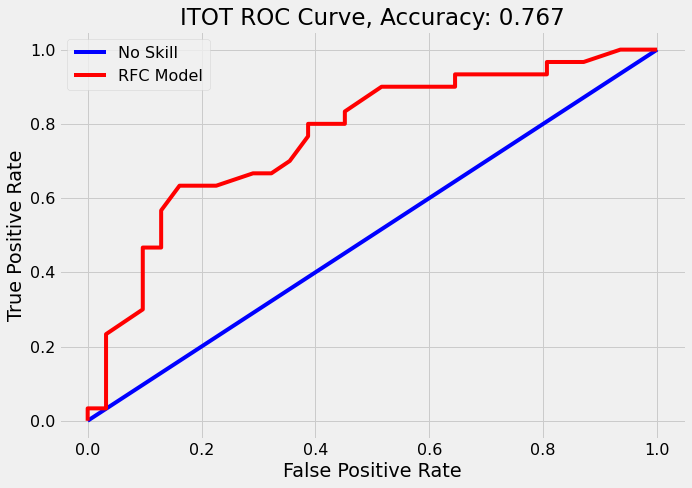

In [29]:
plt.rcParams['font.size'] = 16
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, y_probs)

plt.figure(figsize=(10,7))
plt.plot(base_fpr, base_tpr, 'b', label='No Skill')
plt.plot(model_fpr, model_tpr, 'r', label='RFC Model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{symbol} ROC Curve, Accuracy: {round(roc_value, 3)}');

### Measures of Performance: Confusion Matrix

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:    0.0s finished


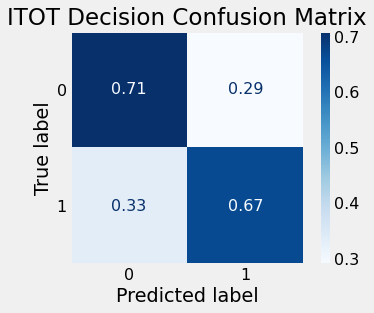

In [30]:
plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams['font.size'] = 16
disp = plot_confusion_matrix(rfc
                           , X_test
                           , y_test
                           , cmap=plt.cm.Blues
                           , normalize='true'
                     )
disp.ax_.grid(False)
disp.ax_.set_title(f'{symbol} Decision Confusion Matrix');

### Measures of Performance: Precision Recall Curve

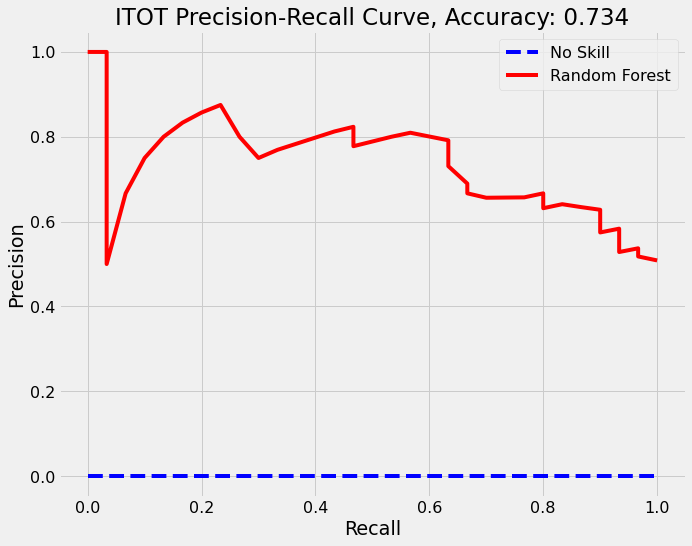

In [31]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10,8)
rf_prec, rf_recall, _ = precision_recall_curve(y_test, y_probs)
plt.plot([0, 0], linestyle = '--', color = 'b', label='No Skill')
plt.plot(rf_recall, rf_prec, color='r', label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title(f'{symbol} Precision-Recall Curve, Accuracy: {round(auc(rf_recall, rf_prec), 3)}');

### Measure of Performance: Feature Importances

In [32]:
feature_df = pd.DataFrame({'feature': X_train.columns
                           , 'importances': rfc.feature_importances_
                          }).sort_values('importances', ascending=False)
feature_df

,feature,importances
5,Volume,0.218476
4,Adj Close,0.171703
3,Close,0.163332
2,Low,0.151209
1,High,0.150739
0,Open,0.144542


In [33]:
stock_df_bal.head()

,Open,High,Low,Close,Adj Close,Volume,percent change,decision
0,65.309998,65.400002,64.330002,64.370003,63.094231,1867900,0.014393,0
1,45.020000,45.590000,45.020000,45.480000,40.514057,142400,-0.010218,0
2,38.080002,38.119999,37.875000,37.959999,33.057110,186200,0.003151,0
3,45.735001,45.904999,45.375000,45.884998,41.275024,533600,-0.003280,0
4,49.270000,49.310001,49.000000,49.029999,45.623409,482300,0.004871,0


### Make A Prediction

In [34]:
last = stock_df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].iloc[-1]
last

Open             69.339996
High             70.680000
Low              70.440002
Close            70.450897
Adj Close        70.450897
Volume       109269.000000
Name: 2020-06-19 00:00:00, dtype: float64

In [35]:
if rfc.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {symbol} on the {interval} interval for {round(perc_inc *100, 1)}% increase.')
else:
    print(f'Sell or hold {symbol} on the {interval} interval.')

Sell or hold ITOT on the 1d interval.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:    0.0s finished


# 